In [51]:
from editor import Editor

editor = Editor()
editor.load('creatures/root.json')
editor.run()

File saved as: creatures/root.json


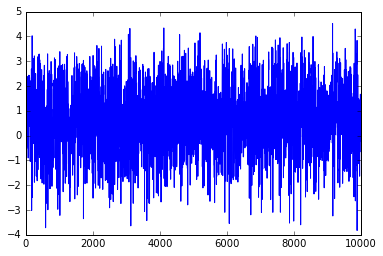

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
from engine import Engine
from pyglet.window import key
import util

# train your model to (hopefully) walk by running this cell

# hit s to speed up training, and s again to watch the best set of weights
# use the up and down arrow keys to introduce more or less randomness in sampled torques

# this cell is an experiment with policy improvement
# the agent's joint torques (continuous, action) are randomly sampled from means output by a neural network
# the gradient which will shift the means given the state, is accumulated into a decaying single gradient
# if the agent experiences a large reward, we add the gradient to its weights, "reinforcing" the recent behavior
# in the case of a negative reward, we subtract the gradient, inhibiting recent behavior (hopefully!)

FILE = 'creatures/leggy2.json'

direction = 1

# Physics engine and window
LOWER_LIM = -.1 * np.pi
UPPER_LIM = .1 * np.pi
LIMIT = True
ANGLE_RANGE = UPPER_LIM - LOWER_LIM if LIMIT else np.pi*2.0

engine = Engine(caption='Train', fps=60, ppm=15,width=1280, height=720, gravity=(0, -50), joint_limit=LIMIT, \
               upper_angle=UPPER_LIM, lower_angle=LOWER_LIM, max_torque=10000, \
                linear_damping=0.0, angular_damping=0.0)


# Load creature
engine.load(FILE)

# count joints and body parts
body_count = len(engine.bodies)
joint_count = len(engine.joints)

if body_count == 0 or joint_count == 0:
    engine.close()
    raise RuntimeError("Your model doesn't have any physics bodies or joints")

def features(time_step=0):
    f = []
    
    f += [direction]
    
    for j in engine.joints:
        a = j.angle
        r = (j.upperLimit - j.lowerLimit) if j.limitEnabled else np.pi*2.0
        a %= r
        a = a * 2.0 - 1.0
        f += [a]
        #f += [np.tanh(j.speed)]
        
    for b in engine.bodies:
        a = b.angle % ANGLE_RANGE
        a /= ANGLE_RANGE
        a = a * 2.0 - 1.0
        #f += [a]
        #f += [np.tanh(b.angularVelocity)]
        #f += [np.tanh(b.linearVelocity[0])]
        #f += [np.tanh(b.linearVelocity[1])]
        #f += [np.sin(a)]
        #f += [np.cos(a)]
        #f += [engine.to_window(b.position)[1]/engine.height]
        #f += [engine.to_window(b.position)[0]/engine.width]
        
        # collision
        if len(b.contacts) > 0:
            f += [1.0]
        else:
            f += [0.0]
    
    #f += [np.sin(time_step / 2.0)] # Creature's heartbeat? :-)
    f += [np.cos(time_step / 2.0)]
    f += [np.sin(time_step)]
    #f += [np.sin(time_step * 2.0)]
    
    f += [1] # bias
    return np.array([f])

PHYS_STEPS = 20
total_r = 0.0
learning_rate = .0002
variance = 6 # increase or decrease deviation from means output by nn
hdim = 32

# tanh:
act = lambda x: np.tanh(x)
act_p = lambda x: 1.0 - np.tanh(x)**2

W1 = util.randn([features().shape[1], hdim]) # initial set of weights
W2 = util.randn([hdim + 1, joint_count]) # initial set of weights

rs = []
avg_r = 0
t = 0

g1 = np.zeros_like(W1)
g2 = np.zeros_like(W2)


speedup = False
running = True

while running:

    engine.window.dispatch_events()

    if engine.exited():
        running = False
        reset = True
        
    # keyboard input
    up = engine.window.pressed(key.UP)
    down = engine.window.pressed(key.DOWN)
    left = engine.window.pressed(key.LEFT)
    right = engine.window.pressed(key.RIGHT)
    
    
    if up or down:
        variance += 0.1 if up else -0.1
        variance = max(variance, 0.0)
        variance = np.round(variance, 2)
        
    if left or right:
        direction += 0.1 if right else -0.1
        direction = np.round(direction, 1)
        
    if engine.window.pressed(key.S):
        speedup = not speedup
        
    if engine.window.pressed(key.R):
        W1 = util.randn(W1.shape)
        W2 = util.randn(W2.shape)
        g1[:] = 0
        g2[:] = 0
        
    engine.window.reset_keys()
    
    # mouse input
    
    if engine.window.mouse_pressed:
        engine.create_mouse_joint()
    else:
        engine.destroy_mouse_joint()

    engine.update_mouse_joint()
    
    text = 'timestep: {} avg reward: {} variance: {} direction: {}'.format(\
            t, np.round(avg_r, 3), variance, direction)
    
    # network
    
    x = features(t)
    x += np.random.randn(x.shape[0], x.shape[1]) * 0.1
    z1 = x.dot(W1)
    h1 = act(z1)
    h1 = np.concatenate((h1, np.ones([1, 1])), axis=1)
    z2 = h1.dot(W2)
    h2 = act(z2) * 4

    if variance > 0:
        torques = np.array([np.random.normal(loc=u, scale=np.sqrt(variance)) for u in h2[0]])
    else:
        torques = h2[0]

    start_p = engine.body_position()

    for i, j in enumerate(engine.joints):
        j.motorSpeed = torques[i]
        
            
    for p in range(PHYS_STEPS):
        engine.step_physics(1)
        
        if not speedup:
            engine.window.clear()
            engine.window.draw_matrices([x.T, W1, h1.T, W2, h2.T, g1, g2], recalc=(p==0))
            engine.window.draw_text(text)
            engine.render()
            engine.clock_tick()
        
    if speedup:
        if t % 1000 == 0:
            engine.window.clear()
            engine.window.draw_matrices([x.T, W1, h1.T, W2, h2.T, g1, g2], recalc=True)
            engine.window.draw_text(text)
            engine.render()
            
            clear_output(wait=True)
            plt.plot(rs[-10000:])
            plt.show()

    end_p = engine.body_position()

    reward = -1
    
    if direction == 1:
        reward += end_p[0] - start_p[0]
    elif direction == -1:
        reward += start_p[0] - end_p[0]
    elif direction == 0:
        reward += abs(start_p[1] - end_p[1]) - abs(start_p[0] - end_p[0])

    reward /= PHYS_STEPS
    
    avg_r += 0.001 * (reward - avg_r)
    rs += [reward]

    # train
    
    delta = (torques - h2) # /variance
    dz2 = np.multiply(delta, 4 * act_p(z2))
    dh1 = W2.dot(dz2.T).T
    dz1 = np.multiply(dh1[:, :-1], act_p(z1))

    g1 += np.multiply(x.T, dz1)
    g2 += np.multiply(h1.T, dz2)

    diff = reward - avg_r
    #diff = np.tanh(diff)
    
    W1 += learning_rate * g1 * diff
    W2 += learning_rate * g2 * diff

    g1 *= 0.8
    g2 *= 0.8
    
    # get a new random direction
    
    if speedup and np.random.randint(0, 10) == 0:
        direction = np.random.randint(0, 3) - 1
        
    # bound the creature
    
    if end_p[0] > engine.width/2 + 400:
        engine.set_position((engine.width/2 - 350, end_p[1]), zero_vel=False)
    elif end_p[0] < engine.width/2 - 400:
        engine.set_position((engine.width/2 + 350, end_p[1]), zero_vel=False)

    t += 1

engine.close()